In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M-q-BE0Jffs8X0WsAJmgHW28QtYLhp3E&confirm=t&uuid=2f587c8b-4a2d-4f68-bbbb-19a19e5cec7e&at=AD1-pjEbrMTXSHSgfyvDWO3CEhwa:1674725134127' -O dataset.zip
#!mv dataset.zip "/content/drive/MyDrive/Colab Notebooks/Data"

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Data/dataset.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id16_s0_15.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id16_s0_30.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id16_s0_45.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id16_s0_60.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id16_s0_75.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id16_s0_90.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id17_s0_105.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id17_s0_15.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id17_s0_30.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id17_s0_45.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id17_s0_60.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id17_s0_75.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHONE7F_id17_s0_90.png  
 extracting: train/spoof/YOUTUBE_IIYAMAXB_IPHON

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn

from tqdm.auto import tqdm

In [ ]:
import random


def fix_random_seed(seed=None):
    """Fix all random seeds."""
    seed = seed or random.randint(0, 14300631)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"All random seeds are set to {seed}.")

In [ ]:
SEED = 179
fix_random_seed(SEED)

All random seeds are set to 179.


In [ ]:
from pathlib import Path

train_paths = sorted(Path("./train").rglob("*.png"))
train_labels = [path.parent.name for path in train_paths]

val_paths = sorted(Path("./valid").rglob("*.png"))

val_labels = [path.parent.name for path in val_paths]

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, paths, transforms):
        super().__init__()
        self.paths = sorted(paths)
        self.transforms = transforms
        
        self.labels = [path.parent.name for path in self.paths]
        self.classes = np.unique(self.labels).tolist()
        self.label2id = {class_: idx for idx, class_ in enumerate(self.classes)}
        self.id2label = {idx: class_ for idx, class_ in enumerate(self.classes)}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        with Image.open(self.paths[idx]) as im:
                if im.mode != "RGB":
                    im = im.convert("RGB")
                else:
                    im.load()
                sample = self.transforms(im)
        label = self.label2id[self.labels[idx]]
        return sample, label

In [ ]:
import torchvision.transforms as T

base_transforms = T.Compose([
    T.ToTensor(),
    T.Resize(size=(224, 224)),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
trainset = ImageDataset(train_paths, transforms=base_transforms)
valset = ImageDataset(val_paths, transforms=base_transforms)

In [ ]:
def show_six_random_samples(dataset):
    sample_ids = np.random.choice(len(dataset), 6)
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = [ax for ax_row in axes for ax in ax_row]
    for sample_id, ax in zip(sample_ids, axes):
        sample, label_id = dataset[sample_id]
        label = dataset.id2label[label_id]
        array = 0.5 * sample.permute(1, 2, 0).numpy() + 0.5
        ax.imshow(array)
        ax.set_title(f"{label} ({label_id = }) [{array.shape[0]} x {array.shape[1]}]")
        # отключаем координатную сетку
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [ ]:
from sklearn.metrics import classification_report


def eval_model(model, dataloader, criterion, device, classes, make_report=False):
    model = model.to(device)
    scores, ground_truth = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            scores.append(logits)
            ground_truth.append(labels)
        scores = torch.cat(scores)
        ground_truth = torch.cat(ground_truth)
        loss = criterion(scores, ground_truth).item()

        predictions = torch.argmax(scores, dim=1)
        accuracy = (predictions == ground_truth).sum().item() / ground_truth.size(0)
    if make_report:
        predictions = predictions.cpu().numpy()
        ground_truth = ground_truth.cpu().numpy()
        report = classification_report(ground_truth, predictions, target_names=classes, zero_division=0)
    else:
        report = None
    return loss, accuracy, report

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, classes, scheduler=None):
    history = []
    model = model.to(device)
    with tqdm(total=epochs, desc='Epoch') as epoch_pbar:
        for _ in range(epochs):
            running_loss = 0
            running_corrects = 0
            running_data = 0
            model.train()
            with tqdm(total=len(train_loader), desc='Batch', leave=False) as batch_pbar:
                for batch_count, (images, labels) in enumerate(train_loader, 1):
                    images = images.to(device)
                    labels = nn.functional.one_hot(labels, num_classes=2).to(device)
                    # optimization part
                    optimizer.zero_grad()
                    logits = model(images).to(device)

                    loss = criterion(logits.float(), labels.float())

                    loss.backward()
                    optimizer.step()
                    if scheduler is not None:
                        scheduler.step()
                    # calculate metrics
                    running_loss += loss.item()
                    predicts = torch.argmax(logits, dim=1)
                    predicts = nn.functional.one_hot(predicts, num_classes=2).to(device)
                    running_data += images.size(0)
                    running_corrects += (predicts == labels).sum().item()
                    # save metrics history
                    history.append({'train_loss': loss.item(), 'train_acc': running_corrects / running_data})
                    # update progress bar
                    batch_pbar.set_postfix(loss=running_loss / batch_count, acc=running_corrects / running_data)
                    batch_pbar.update()
            
            #val_loss, val_acc, _ = eval_model(model, val_loader, criterion, device, classes)
            #history[-1]['val_loss'] = val_loss
            #history[-1]['val_acc'] = val_acc
            #epoch_pbar.set_postfix(
            #    train_loss=running_loss / len(train_loader),
            #    val_loss=val_loss,
            #    train_acc=history[-1]['train_acc'],
            #    val_acc=val_acc,
            #)
            
            epoch_pbar.update()
    return pd.DataFrame(history)

In [ ]:
def predict(model, dataloader, device):
    model = model.to(device)
    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc='Predicting'):
            logits = model(images.to(device))
            predictions.append(torch.argmax(logits, dim=1).cpu().numpy())
    return np.concatenate(predictions)

In [ ]:
def plot_experiments(experiments):
    fig, axes = plt.subplots(2, 2, figsize=(25, 13))
    axes = [ax for ax_row in axes for ax in ax_row]
    for name, history in experiments:
        for metric, ax in zip(history.columns, axes):
            marker = 'o' if metric.startswith('val_') else None
            history[metric].dropna().plot(ax=ax, label=name, marker=marker)
    for metric, ax in zip(history.columns, axes):
        ax.set_title(f'{metric} history')
        ax.set_xlabel('Iteration (batch)')
        ax.legend()
    plt.show()

In [ ]:
from torch.utils.data import DataLoader


#train_loader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=10, pin_memory=True)
val_loader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

device = torch.device('cuda:0')

In [ ]:
logits = [len(trainset.labels)/trainset.labels.count('real'), len(trainset.labels)/trainset.labels.count('spoof')]
#logits = [1,1]

In [ ]:
logits = torch.tensor(logits).to(device)

In [ ]:
logits[0].type()

'torch.cuda.FloatTensor'

In [ ]:
criterion = nn.BCEWithLogitsLoss(pos_weight=logits)

In [ ]:
experiments = {} 

In [ ]:
def predict(model, dataloader, device):
    model = model.to(device)
    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc='Predicting'):
            logits = model(images.to(device))
            predictions.append(torch.argmax(logits, dim=1).cpu().numpy())
    return np.concatenate(predictions)

# Константы

In [ ]:
IN_CHANNELS = 3
N_CLASSES = 2
LR = 1e-3
EPOCHS = 30

In [ ]:
criterion

BCEWithLogitsLoss()

In [ ]:
EPOCHS = 30

# Аугментация

In [ ]:
augmentation = T.Compose([
    T.ToTensor(),
    T.RandomAffine(degrees=(10, 30), translate=(0.1, 0.2)),
    T.Resize(size=(224, 224)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
trainset.transforms = augmentation

# Модель

In [ ]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, pin_memory=True)

In [ ]:
import torchvision

In [ ]:
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
from torchsummary import summary

summary(model.cuda(), trainset[0][0].size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.fc = nn.Linear(512, N_CLASSES)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.2 * LR, total_steps=EPOCHS* len(train_loader))
train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    classes=trainset.classes,
    scheduler=scheduler,
)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

Batch:   0%|          | 0/65 [00:00<?, ?it/s]

,train_loss,train_acc
0,0.916003,1.546875
1,0.938513,1.539062
2,0.817225,1.583333
3,0.726185,1.628906
4,0.698372,1.634375
...,...,...
1945,0.000111,1.999232
1946,0.000472,1.999244
1947,0.000536,1.999256
1948,0.004010,1.999268


UnboundLocalError: ignored

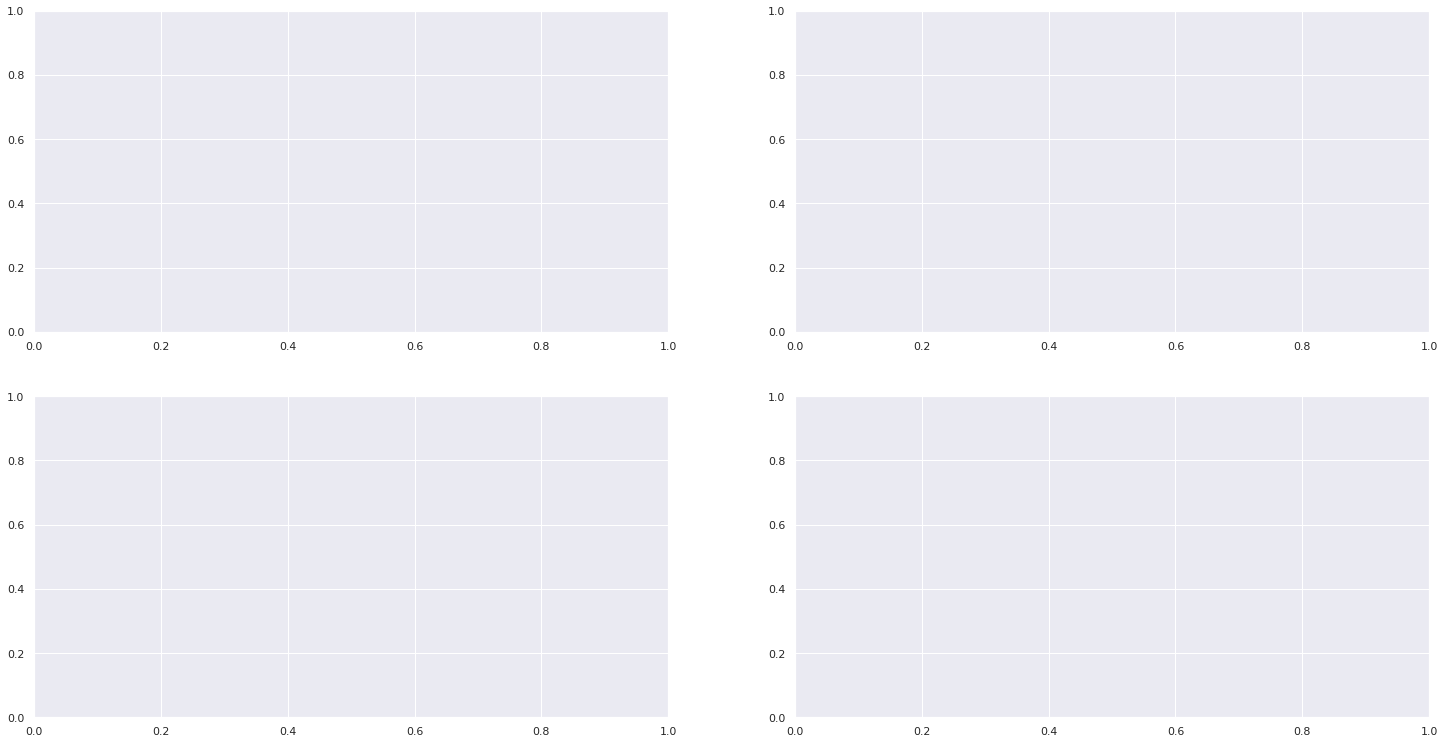

In [ ]:
plot_experiments(experiments.items())

In [ ]:
torch.save(model.state_dict(), "model-7-09-03")

In [ ]:
!mv "model-7-09-03" "/content/drive/MyDrive/Colab Notebooks/Data"

# Test

In [ ]:
#test_paths = sorted(Path("/content/MyTest").rglob("*.png"))
#print(f"Found {len(test_paths)} image files.")

In [ ]:
testset = ImageDataset(test_paths, transforms=base_transforms)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
model = torchvision.models.mobilenet_v3_large()
model.fc = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(512, 2),
    )
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Data/model-3-02-02', map_location=torch.device('cpu')))

In [ ]:
def Get_Submission(model, data, device):

        return predict(model, data, device)

In [ ]:
Get_Submission(model, test_loader, device)

In [ ]:
for img in loader:
  print(img[0].size())
  break

In [ ]:
trainset.clases

In [ ]:
loss, acc, report = eval_model(model, val_loader, criterion, device, valset.classes, True)

In [ ]:
print(report)

In [ ]:
target = torch.ones([10, 64], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([10, 64], 1.5)  # A prediction (logit)
pos_weight = torch.ones([64])  # All weights are equal to 1
crit = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
crit(output, target)  # -log(sigmoid(1.5))